In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import gmplot
import seaborn as sns
from sklearn.cluster import KMeans

%matplotlib inline
sns.set_style("ticks")

In [2]:
# read in data of interest
listings = pd.read_csv('listings_detail.csv', 
                       usecols=['id','host_since','host_response_rate','host_is_superhost','host_identity_verified','neighbourhood_cleansed',
                                'latitude','longitude','property_type','room_type','bathrooms','bedrooms','beds','price','number_of_reviews',
                                'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                                'review_scores_communication','review_scores_location','review_scores_value'])

In [3]:
listings.head().T

,0,1,2,3,4
id,2577,5396,7397,7964,8522
host_since,2008-09-09,2009-02-14,2008-08-30,2009-06-18,2009-07-13
host_response_rate,80%,NaN,NaN,100%,NaN
host_is_superhost,f,f,t,f,f
host_identity_verified,t,t,t,t,f
neighbourhood_cleansed,Entrepôt,Hôtel-de-Ville,Hôtel-de-Ville,Opéra,Ménilmontant
latitude,48.8699,48.851,48.8576,48.8746,48.8653
longitude,2.36251,2.35869,2.35275,2.34341,2.39326
property_type,Loft,Apartment,Apartment,Apartment,Apartment
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt


In [4]:
listings.info()   # there are many missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58067 entries, 0 to 58066
Data columns (total 22 columns):
id                             58067 non-null int64
host_since                     58057 non-null object
host_response_rate             27145 non-null object
host_is_superhost              58057 non-null object
host_identity_verified         58057 non-null object
neighbourhood_cleansed         58067 non-null object
latitude                       58067 non-null float64
longitude                      58067 non-null float64
property_type                  58067 non-null object
room_type                      58067 non-null object
bathrooms                      57994 non-null float64
bedrooms                       58008 non-null float64
beds                           57812 non-null float64
price                          58067 non-null object
number_of_reviews              58067 non-null int64
review_scores_rating           44966 non-null float64
review_scores_accuracy         44906 no

In [5]:
# there is no missing value in 'price'
# need to remove '$' and ',', also convert from string to numeric value
listings['price'] = [float(x.replace('$','').replace(',','')) for x in listings['price']]

In [6]:
listings['price'].describe()    # there are some zeros and some outliers in 'price'

count    58067.000000
mean       113.934352
std        240.480314
min          0.000000
25%         57.000000
50%         80.000000
75%        120.000000
max      25000.000000
Name: price, dtype: float64

In [7]:
zeroprice = listings[listings['price']==0]
zeroprice.shape[0]        # there are 8 listings with price of zero, maybe they are for free?

8

In [8]:
listings['price'].quantile(0.99)   # 99% of the listing price is below 700

700.0

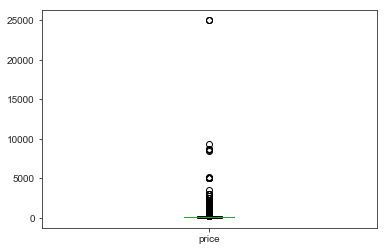

In [9]:
listings['price'].plot(kind='box')   # presence of outliers makes the plot hard to see

In [10]:
# remove top 1% listing price from the data
listings = listings[listings['price'] <= listings['price'].quantile(0.99)]

Text(0.5, 1.0, 'K-Means Elbow Plot')

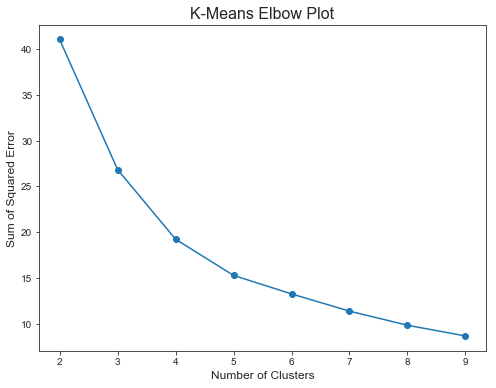

In [11]:
# k-means clustering based on locations (latitudes & longitudes) of the airbnb listings
# first use elbow method to get an idea of the number of clusters to use for k-means

locations = listings[['latitude','longitude']]
sse = []
for n in range(2,10):
    km = KMeans(n_clusters=n)
    km.fit(locations)
    # km.inertia_: sum of squared distances of samples to their closest cluster center
    sse.append(km.inertia_)

plt.figure(figsize=(8,6))    
plt.plot(range(2,10), sse, '-o')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Sum of Squared Error', fontsize=12)
plt.title('K-Means Elbow Plot', fontsize=16)

In [12]:
# from the above elbow plot, it seems 5 clusters would be a good choice.
km = KMeans(n_clusters=5, random_state=0)
km.fit(locations)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [13]:
listings['Cluster'] = km.labels_
listings['Cluster'].value_counts(sort=False)

0    11299
1     9759
2     8621
3    12282
4    15536
Name: Cluster, dtype: int64

In [14]:
# visualize using gmplot on google maps
# Paris coordinates: 48.8566° N, 2.3522° E
gmap = gmplot.GoogleMapPlotter(48.8566, 2.3522, 13)
# to plot clusters with different colors
colors = ['cyan','lime','deeppink','blue','gold']
for n in range(0,5):
    gmap.scatter(listings[listings['Cluster']==n].latitude, listings[listings['Cluster']==n].longitude, 
                 colors[n], size=30, marker=False)

# to plot some tourist attractions in Paris    
# Eiffel Tower: 48.8584° N, 2.2945° E
# Louvre Museum: 48.8606° N, 2.3376° E
# Cathédrale Notre-Dame: 48.8530° N, 2.3499° E
# Arc de Triomphe: 48.8738° N, 2.2950° E
latList = [48.8584, 48.8606, 48.8530, 48.8738]
lonList = [2.2945, 2.3376, 2.3499, 2.2950]
gmap.scatter(latList, lonList, 'red', size=100, marker=True)
gmap.draw("Paris_Airbnb.html")

In [15]:
# average listing price by cluster
clusterPrice = listings.groupby(['Cluster']).price.mean().sort_values(ascending=False).reset_index()
clusterPrice

,Cluster,price
0,1,123.258121
1,2,110.528129
2,4,106.140191
3,3,96.586387
4,0,77.380388


In [16]:
# keep colors in the bar chart consistent with k-means cluster map
mapcolor=[]
for i in range(0,5):
    mapcolor.append(colors[clusterPrice.Cluster[i]])
mapcolor

['lime', 'deeppink', 'gold', 'blue', 'cyan']

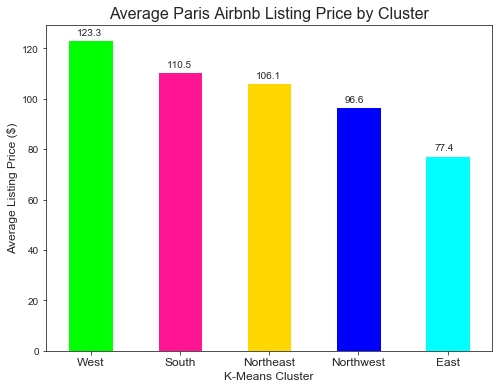

In [17]:
ax = clusterPrice.plot(x='Cluster', y='price', kind='bar', color=mapcolor, figsize=(8,6))
plt.xlabel('K-Means Cluster', fontsize=12)
plt.ylabel('Average Listing Price ($)', fontsize=12)
plt.title('Average Paris Airbnb Listing Price by Cluster', fontsize=16)
plt.legend().set_visible(False)
plt.xticks(rotation=0)
ax.set_xticklabels(['West','South','Northeast','Northwest','East'], fontsize=12)
for n in range(0,5):
    ax.text(n-0.15, clusterPrice.price[n]+2, round(clusterPrice.price[n],1))
    
plt.savefig('Avg Cluster Price.jpeg', dpi=300)

In [18]:
listings['host_since_year'] = pd.to_datetime(listings['host_since']).dt.year
listings['host_since'].isnull().sum()    # there are 10 missing values in 'host_since'

10

In [19]:
clusterGrowth = listings.groupby(['host_since_year', 'Cluster']).size().reset_index()
clusterGrowth.rename(columns={0:'listingCount'}, inplace=True)
clusterGrowth.head()

,host_since_year,Cluster,listingCount
0,2008.0,0,1
1,2008.0,4,2
2,2009.0,0,11
3,2009.0,1,19
4,2009.0,2,11


In [20]:
# since 2019 listings info is incomplete
# for plotting purpose, remove listings with 'host_since'=2019 to avoid displaying misleading info
clusterGrowth = clusterGrowth[clusterGrowth['host_since_year']!=2019]

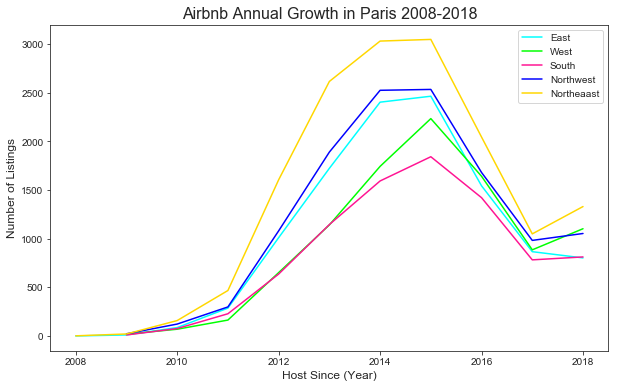

In [21]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
sns.lineplot(x='host_since_year', y='listingCount', hue='Cluster', data=clusterGrowth, palette=colors, ax=ax)
ax.set_xlabel('Host Since (Year)', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
ax.set_title('Airbnb Annual Growth in Paris 2008-2018', fontsize=16)
plt.legend(['East', 'West', 'South', 'Northwest', 'Northeaast'])

plt.savefig('Cluster Growth.jpeg', dpi=300)

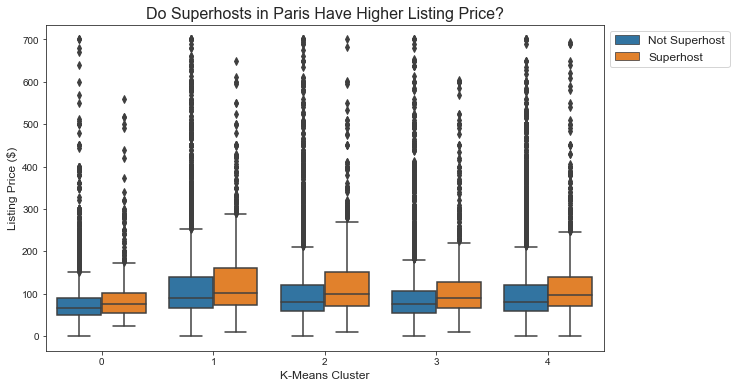

In [22]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(x='Cluster', y='price', hue='host_is_superhost', data=listings)
ax.set_xlabel('K-Means Cluster', fontsize=12)
ax.set_ylabel('Listing Price ($)', fontsize=12)
ax.set_title('Do Superhosts in Paris Have Higher Listing Price?', fontsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Not Superhost','Superhost'], bbox_to_anchor=(1,1), fontsize=12)

In [23]:
# read in neighbourhood polygons using geopandas
neighbourhoods_map = gpd.read_file('neighbourhoods.geojson')
neighbourhoods_map.head()

,neighbourhood,neighbourhood_group,geometry
0,Batignolles-Monceau,None,"(POLYGON ((2.295167 48.873955, 2.29504 48.8737..."
1,Palais-Bourbon,None,"(POLYGON ((2.320903 48.863057, 2.320941 48.863..."
2,Buttes-Chaumont,None,"(POLYGON ((2.389429 48.901218, 2.390136 48.901..."
3,Opéra,None,"(POLYGON ((2.339777 48.882029, 2.339816 48.882..."
4,Entrepôt,None,"(POLYGON ((2.364686 48.884369, 2.364855 48.884..."


In [24]:
neighbourhoods_map.drop(['neighbourhood_group'], axis=1, inplace=True)
neighbourhoods_map.info()    
# there are 20 neighborhoods in Paris data
# justify use of k-means: reduce the number of variables related to spatial distribution for effective visualization

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
neighbourhood    20 non-null object
geometry         20 non-null object
dtypes: object(2)
memory usage: 400.0+ bytes


In [25]:
# calculate average listing price of each neighbourhood
neighbourhoods_price = listings.groupby(['neighbourhood_cleansed']).price.mean().reset_index()
neighbourhoods_price.columns = ['neighbourhood', 'price_mean']
neighbourhoods_price.head()

,neighbourhood,price_mean
0,Batignolles-Monceau,94.695720
1,Bourse,127.348983
2,Buttes-Chaumont,71.569675
3,Buttes-Montmartre,79.041887
4,Entrepôt,92.056408


In [26]:
# merge neighbourhoods map and price into one dataframe
neighbourhoods = pd.merge(neighbourhoods_map, neighbourhoods_price, on=['neighbourhood'], how='left')
neighbourhoods.head()

,neighbourhood,geometry,price_mean
0,Batignolles-Monceau,"(POLYGON ((2.295167 48.873955, 2.29504 48.8737...",94.695720
1,Palais-Bourbon,"(POLYGON ((2.320903 48.863057, 2.320941 48.863...",152.441414
2,Buttes-Chaumont,"(POLYGON ((2.389429 48.901218, 2.390136 48.901...",71.569675
3,Opéra,"(POLYGON ((2.339777 48.882029, 2.339816 48.882...",108.777735
4,Entrepôt,"(POLYGON ((2.364686 48.884369, 2.364855 48.884...",92.056408


Text(0.5, 1.0, 'Average Listing Price By Neighbourhood')

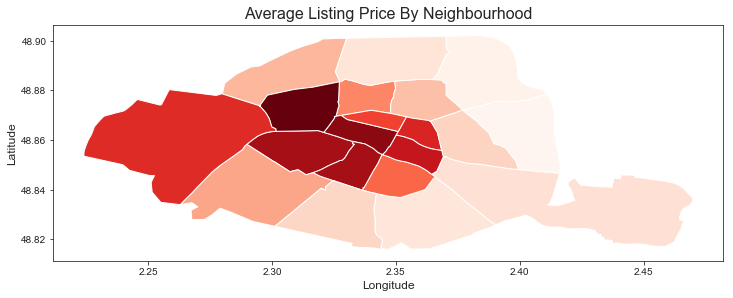

In [27]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
neighbourhoods.plot(column='price_mean', cmap='Reds', legend=False, ax=ax)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Average Listing Price By Neighbourhood', fontsize=16)

In [28]:
roomType_price = listings.groupby(['Cluster','room_type']).price.mean().reset_index()
roomType_price.head()

,Cluster,room_type,price
0,0,Entire home/apt,82.132846
1,0,Private room,52.449530
2,0,Shared room,32.883721
3,1,Entire home/apt,127.960099
4,1,Private room,93.426117


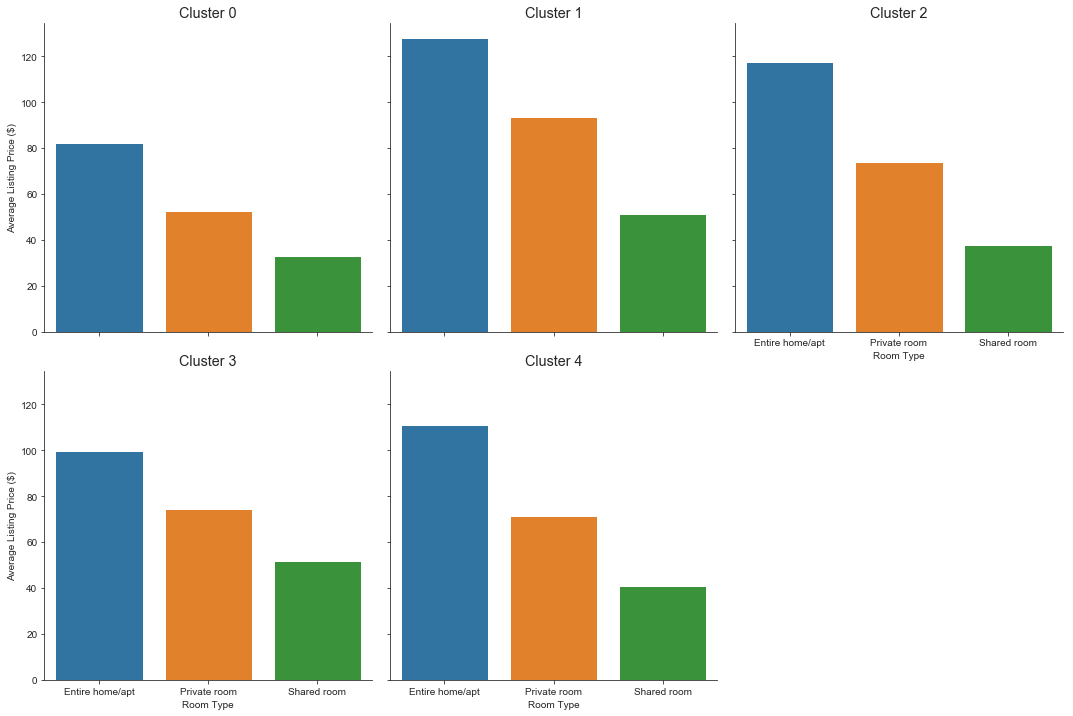

In [29]:
g = sns.catplot(x='room_type', y='price', col='Cluster', data=roomType_price, col_wrap=3, kind='bar')
sns.set(font_scale=1.2)
g.set_axis_labels('Room Type', 'Average Listing Price ($)')
g.set_titles("{col_var} {col_name}")

In [30]:
review_type = ['review_scores_rating',
               'review_scores_accuracy',
               'review_scores_cleanliness',
               'review_scores_checkin',
               'review_scores_communication',
               'review_scores_location',
               'review_scores_value']

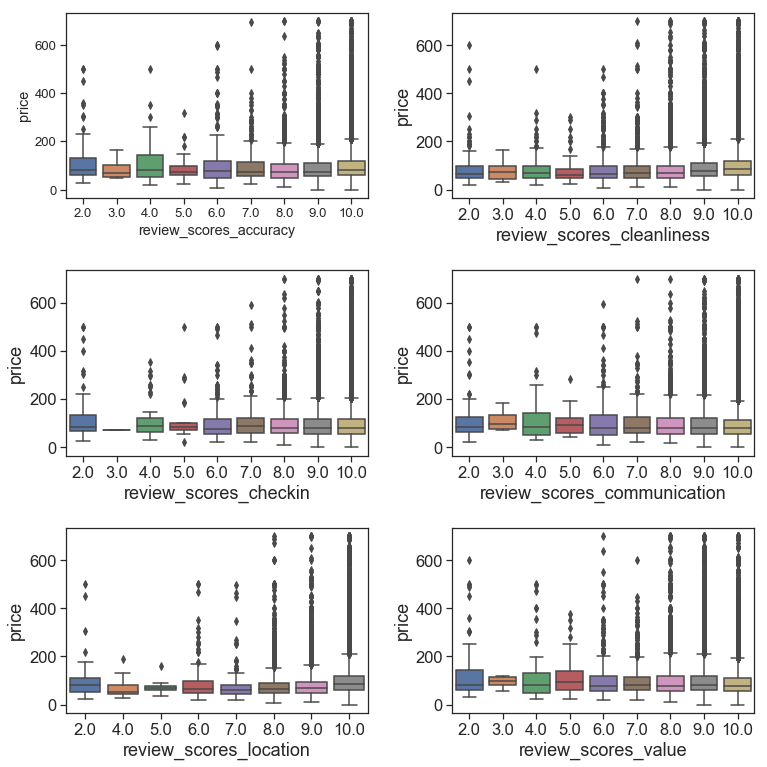

In [31]:
fig = plt.figure(figsize=(11, 11))
for n in range(1, 7):
    sns.set_style("ticks")
    fig.add_subplot(3, 2, n) 
    g = sns.boxplot(x=review_type[n], y='price', data=listings)
    sns.set(font_scale=1.5)   
# airbnb guests in Paris are concerned about location and cleanliness most
plt.tight_layout()
plt.savefig('Reviews.jpeg', dpi=300)